# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [114]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [115]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
618,4531,49483,London/Essex,17-03-2020,NEW PRICE LIST NEW METHODS NO NONSENSE Check o...,Extremely Negative
20004,28188,73140,JHB,26-03-2020,A lady fro @CheckersSA Brits tells me to hide ...,Positive
25506,35041,79993,NaN,06-04-2020,@airvistara @IndiGo6E @narendramodi Tickets pr...,Positive
5223,10146,55098,Fiji,19-03-2020,COVID-19- STOP PANIC BUYING\r\r\n\r\r\nWhile ...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [116]:
df['Sentiment_bin'] = np.where(df['Sentiment'].isin(['Positive', 'Extremely Positive']), 1, 0)
# -- YOUR CODE HERE --
df['Sentiment_bin'].sample(5)

,Sentiment_bin
3554,1
24006,1
7430,1
28858,0
31630,0


Сбалансированы ли классы?

In [117]:
# -- YOUR CODE HERE --
c = df['Sentiment_bin'].value_counts()
c

,count
Sentiment_bin,
1,18046
0,15398


единиц больше, но не критично, дисбаланс совсем небольшой, допустимый, так что можно считать, что классы не идеально, но все-таки сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [118]:
df.isnull().sum()
# -- YOUR CODE HERE --

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0
Sentiment_bin,0


In [119]:
df = df.fillna("Unknown")
df.isnull().sum()

,0
UserName,0
ScreenName,0
Location,0
TweetAt,0
OriginalTweet,0
Sentiment,0
Sentiment_bin,0


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [120]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, random_state=0)# -- YOUR CODE HERE --

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [121]:
# -- YOUR CODE HERE --
text_train = " ".join(train['OriginalTweet'])
tokens = text_train.lower().split()
tokens_count = pd.Series(tokens).value_counts().to_dict()
tokens_count

{'the': 26815,
 'to': 23373,
 'and': 14684,
 'of': 13012,
 'a': 11737,
 'in': 11198,
 'for': 8566,
 '#coronavirus': 8223,
 'is': 7383,
 'are': 7050,
 'you': 5467,
 'on': 5452,
 'i': 5340,
 'at': 4642,
 'this': 4581,
 'with': 4063,
 'prices': 3891,
 'food': 3820,
 'we': 3787,
 'have': 3770,
 'that': 3741,
 'as': 3694,
 'be': 3570,
 'grocery': 3469,
 'supermarket': 3288,
 'people': 3175,
 'covid-19': 3173,
 'store': 3155,
 'it': 3150,
 'from': 3045,
 'all': 2808,
 'your': 2784,
 'will': 2726,
 'not': 2714,
 '#covid19': 2471,
 'our': 2460,
 'my': 2445,
 '&amp;': 2314,
 'they': 2309,
 'has': 2304,
 'consumer': 2245,
 'by': 2236,
 'or': 2234,
 'can': 2202,
 'but': 2159,
 'if': 2142,
 '19': 2111,
 'out': 2026,
 'more': 2008,
 'up': 1987,
 'their': 1972,
 'during': 1908,
 'no': 1898,
 'how': 1850,
 'so': 1837,
 'covid': 1769,
 'get': 1759,
 'about': 1726,
 'who': 1670,
 '#covid_19': 1660,
 'online': 1648,
 'shopping': 1621,
 'like': 1550,
 'need': 1549,
 'what': 1541,
 'just': 1540,
 'panic':

Какой размер словаря получился?

In [122]:
len(tokens_count)# -- YOUR CODE HERE --

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [123]:
# -- YOUR CODE HERE --
top_10 = sorted(tokens_count.items(), key=lambda x: x[1], reverse=True)[:10]

In [124]:
top_10

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

в основном вывелись все стоп-слова ("the", "to", "and", ...), что логично, так как стоп-слова- это те, которые встречаются очень часто и практически в каждом тексте и не несут особого смысла, также вывелось слово "#coronavirus", так как оно является смысловым и самым важным в тестке, по нему можнл понять о чем текст


Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [125]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
new_tokens = list(pd.Series(tokens_count)[~pd.Series(tokens_count).index.isin(stopwords.words('english'))].items())
new_top = dict(sorted(new_tokens, key=lambda x: x[1], reverse=True)[:10])
# -- YOUR CODE HERE --
new_top

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'#coronavirus': 8223,
 'prices': 3891,
 'food': 3820,
 'grocery': 3469,
 'supermarket': 3288,
 'people': 3175,
 'covid-19': 3173,
 'store': 3155,
 '#covid19': 2471,
 '&amp;': 2314}

**Ответ:** новый топ-10 без стоп-слов вывод слова, отображающие тематику текста, дает нам понять что в нем говорится о ковиде ('#coronavirus', 'covid-19', '#covid19') и о продуктах, супермаркетах и ценах в период пандемии (food, grocery, supermarket, store, prices). также слово 'people' встречается довольно часто, так как текст о маштабной социальной проблеме, котора может коснуться каждого

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [126]:
top_min =dict(sorted(new_tokens, key=lambda x: x[1], reverse=False)[:20])
top_min

{'https://t.co/7j2y3rsld9': 1,
 'https://t.co/1m881cwfuv': 1,
 'https://t.co/2s1aljdwdd': 1,
 'acquiring.': 1,
 'https://t.co/pd6ual9yfi': 1,
 'https://t.co/lw1r0rm7xs': 1,
 'https://t.co/5cbliqzx7l': 1,
 'now.when': 1,
 'milion': 1,
 'skellig': 1,
 'coast!': 1,
 'closer!)': 1,
 '@skelligsix18': 1,
 '#skelligcoast2kms': 1,
 'lunchboxes!': 1,
 'fights.': 1,
 'through?': 1,
 'https://t.co/rbaevqdzxk': 1,
 'keyworker(supermarket),': 1,
 'https://t.co/9ascqvqk0o': 1}

**Ответ:**

1.эти токены непопулярны, так как большенство из них это уникальные значения (ссылки или ники пользователей), также есть слова с опечатками (milion) и те, на конце которых стоят знак препинания из-за которого модель сочла, например, слово 'closer!)' отличным от 'closer' (это потому-что мы использовали команду split(), она не разделяет слова от знаков препинания, делит только по пробелам)
2. С токенами,у которых очень редкая частота обычно не работают, так как они для текста не информативны, уникальные значения можно удалить, а знаки препинания очистить, чтоб не путать модель и улучшить качество ее работы





Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [127]:
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()
c2 = pd.Series(tw.tokenize(text_train)).value_counts()
c2.head(10).to_dict()
# -- YOUR CODE HERE --

{'the': 24337,
 '.': 24108,
 'to': 22933,
 ',': 17571,
 'and': 14354,
 'of': 12904,
 'a': 11045,
 'in': 10573,
 '?': 9524,
 'for': 8228}

**Ответ:** после токенайзера TweetTokenizer в топе помимо стоп-слов можно увидеть знаки препинания, поскольку токенайзер разделил их от слов и считал отдельно, и так как знаки препинания, а в частности такие как ".", ",", "?" встречаются довольно часто в любом тексте, поэтому они попали в наш топ вместе со стоп-словами

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [128]:
from string import punctuation
noise = stopwords.words("english") + list(punctuation)
tokens_dict = c2.to_dict()
new_tokens_dict = {token: count for token, count in tokens_dict.items()if token.lower() not in noise}
top_tokens_dict = dict(list(new_tokens_dict.items())[:10])
top_tokens_dict
# -- YOUR CODE HERE --

{'Â': 7415,
 '\x82': 7311,
 '19': 7167,
 '#coronavirus': 7143,
 '\x92': 4372,
 'prices': 4281,
 'COVID': 4218,
 'food': 3795,
 'store': 3691,
 'supermarket': 3373}

**Ответ:** да, появились какие-то непонятные символы ('Â', '\x82, '\x92'), ну и '19' - часть от covid-19, отделенная при токенизации, ну и остались слова отражающие тематику текста ('prices','COVID','food','store') и хештег '#coronavirus'

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [129]:
# -- YOUR CODE HERE --
sorted_tokens = {token: count for token, count in new_tokens_dict.items() if not (len(token) == 1 and ord(token) >= 128)}
new_top_10 = dict(list(sorted_tokens.items())[:10])
new_top_20 = dict(list(sorted(sorted_tokens.items(), key=lambda x: x[1])[:20]))
new_top_10

{'19': 7167,
 '#coronavirus': 7143,
 'prices': 4281,
 'COVID': 4218,
 'food': 3795,
 'store': 3691,
 'supermarket': 3373,
 'grocery': 3083,
 'people': 3047,
 '#COVID19': 1844}

In [97]:
new_top_20

{'https://t.co/7j2Y3rSld9': 1,
 'https://t.co/1m881CwFUv': 1,
 'ruins': 1,
 'now.When': 1,
 'TELESCOPE': 1,
 'amble': 1,
 'Yelling': 1,
 'https://t.co/g5q23HV8Qz': 1,
 "CIGA's": 1,
 '#LOVE': 1,
 'Legends': 1,
 'https://t.co/MjEBs1UKvC': 1,
 'Universe': 1,
 'Masters': 1,
 'Crews': 1,
 'https://t.co/d9bdaqhsC6': 1,
 'https://t.co/Mrx9h61ffJ': 1,
 "years'-supplies": 1,
 'https://t.co/8Ts1Ja4AAC': 1,
 'lunchboxes': 1}

полученные топы лучше тех, в которых была применина токенизация по пробелам тем, что в них коректнее отсортированы слова, так как учтены и те, после которых идет пунктуация (ток-ция по пробелам определяла их как разные) и удален мусор и символы (при доп фильтрации), также учтена специфика твитов (смайлики и тд)

Единственный момент, где эта токенизация работает нам в минус, это то что выводит число 19 отдельно от ковид

**Ответ:** # -- YOUR ANSWER HERE --

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [130]:
# -- YOUR CODE HERE --
hashtags = {token: count for token, count in tokens_dict.items() if token.startswith('#')}
dict(sorted(hashtags.items(), key=lambda x: x[1], reverse=True)[:10])

{'#coronavirus': 7143,
 '#COVID19': 1844,
 '#Covid_19': 1463,
 '#Coronavirus': 1281,
 '#COVID2019': 927,
 '#toiletpaper': 657,
 '#covid19': 568,
 '#COVID': 542,
 '#CoronaCrisis': 426,
 '#CoronaVirus': 351}

ну они все отображают тематику текста (коронавирус, ковид и тд), и видимо люди еще в панике что могут остаться без туалетной бумаги, так как ее тогда все скупали сильно (высказывают свое недовольство)

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [131]:
# -- YOUR CODE HERE --
links = {token: count for token, count in tokens_dict.items() if token.startswith('https://t.co')}
dict(sorted(links.items(), key=lambda x: x[1], reverse=True)[:10])

{'https://t.co/oXA7SWtoNd': 5,
 'https://t.co/gP3EusapL8': 4,
 'https://t.co/zjNRx6dKKN': 3,
 'https://t.co/G63RP042HO': 3,
 'https://t.co/CATKegAyOY': 3,
 'https://t.co/kuwIpF1KQW': 3,
 'https://t.co/WrLHYzIzAA': 3,
 'https://t.co/WuiEEfSNOj': 3,
 'https://t.co/AZIqCdgrNn': 3,
 'https://t.co/3GBBDpdjat': 3}

**Ответ:** Хештеги отражают обобщённые темы, поэтому они повторяются намного чаще, в то время как ссылки совпадают давольно редко (на этом примере максимум 5 раз), но при этом инфа о ссылке на конкретную страницу тоже может быть полезна для большего понимания темы и пороблемы текста, если ты например собираешься по ним переходить и анализировать, но в большенстве случаев их лучше удалить, так как для модели важна обобщенная лексика а не какие-то редкие ссылки, которые могут только добавить шума

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [132]:
def custom_tokenizer(text):
  tw = TweetTokenizer()
  new_text = tw.tokenize(text.lower())
  tokens = [token for token in new_text if token not in noise and not (len(token) == 1 and ord(token) >= 128) and not token.startswith('https://t.co')]
  return tokens


In [101]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [133]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
X = cv.fit_transform(train['OriginalTweet'])# -- YOUR CODE HERE --

print(len(cv.vocabulary_))

45290


**Ответ:** 45290 уникальных значений при CountVectorizer и 79755 при обычной токенизации по пробелам. Так происходит потому что CountVectorizer удаляет токены длиной в 1 символ, пропускает пробелы и спецсимвол, а также не учитывает пунктуацию и числа, в отличии от токенизации по пробелам, которая собирает весь мусор, не разделяет слова от знаков препинания и считает их уникальным значением ( например, 'covid!' и 'covid' будут считаться разными словами), а также не отфильтровывает всякий бред по типу 'Â', '\x92', '\x80'

Посмотрим на какой-нибудь конкретный твитт:

In [134]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 'Negative')

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [135]:
t = train.iloc[ind]['OriginalTweet']
X_t = cv.transform([t])
n = np.where(X_t.toarray()[0] > 0)[0]
max = n[np.argmax(X_t.toarray()[0][n])]
min = n[np.argmin(X_t.toarray()[0][n])]
inv_vocab = {i: w for w, i in cv.vocabulary_.items()}
print(inv_vocab[max])
print(inv_vocab[min])

#coronavirusoutbreak
#coronavirusoutbreak


**Ответ:** # ну не оч(

  в этой строке все токены имеют частоту 1, а np.argmax(...) и np.argmin(...) выводят первый по порядку токен, но это вовсе не означает что он самый/наименее важный

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)
tfidf.fit(train['OriginalTweet'])
X = tfidf.transform([t])
n = np.where(X.toarray()[0] > 0)[0]
max = n[np.argmax(X.toarray()[0][n])]
min = n[np.argmin(X.toarray()[0][n])]
words = tfidf.get_feature_names_out()
print(words[max], X.toarray()[0][max])
print(words[min], X.toarray()[0][min])

brainless 0.3867641170466375
food 0.11328893069250721


ну вот, другое дело. Сейчас определяется куда лучше, так как TF-IDF учитывает веса слов, то есть их важность конкретно для этого текста, в зависимости от того как часто это слово встречается во всех текстах

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [137]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x or 'great' in x or 'amazing' in x or 'thank' in x or 'happy' in x or 'love' in x or 'support' in x) & (train['Sentiment_bin'] == 1)].sample(1)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Sentiment_bin
28478,38738,83690,Karad Maharash,08-04-2020,Washing hands and using sanitizer is great but...,Extremely Positive,1


In [138]:
train['OriginalTweet'][11074]

'There is time of and then there local shops up the prices to make the most of 19 thank you for understanding splendid  '

ахах ну тут как-будто сарказм чувствуется, но для примера сойдет думаю

In [139]:
text2 = train['OriginalTweet'][11074]
X2 = tfidf.transform([text2])
n = np.where(X2.toarray()[0] > 0)[0]
tokens = tfidf.get_feature_names_out()
top_tokens = sorted([(tokens[i], X2.toarray()[0][i]) for i in n], key=lambda x: x[1], reverse=True)
top_tokens[:5]

[('splendid', np.float64(0.59940910929501)),
 ('understanding', np.float64(0.46947845418137496)),
 ('shops', np.float64(0.31920148922313213)),
 ('thank', np.float64(0.2841327802818781)),
 ('local', np.float64(0.2648370894191772))]

**Ответ:** в целом TfidfVectorizer тут работает хорошо, он выделил слова 'splendid' и 'understanding' как самые важные, и вроде так и есть, они отражают эмоциональную окраску текста (правда в тексте они несут саркастический характер, что модель конечно не может опознать), а  слова 'there', 'then' тут потому что TF-IDF работает без стоп-слов

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [141]:
# -- YOUR CODE HERE --
y_train = train['Sentiment_bin']
texts = train['OriginalTweet']
X_cv = cv.transform(texts)
X_tfidf = tfidf.transform(texts)
print(X_cv.shape)
print(X_tfidf.shape)
print(y_train.shape)

(23410, 45290)
(23410, 45290)
(23410,)


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
y_train = train['Sentiment_bin']
y_test = test['Sentiment_bin']
X_train_cv = cv.fit_transform(train['OriginalTweet'])
X_test_cv = cv.transform(test['OriginalTweet'])
X_train_tfidf = tfidf.fit_transform(train['OriginalTweet'])
X_test_tfidf = tfidf.transform(test['OriginalTweet'])
logreg_cv = LogisticRegression(max_iter=1000)
logreg_tfidf = LogisticRegression(max_iter=1000)
logreg_cv.fit(X_train_cv, y_train)
logreg_tfidf.fit(X_train_tfidf, y_train)
y_cv_train = logreg_cv.predict(X_train_cv)
y_cv_test = logreg_cv.predict(X_test_cv)
y_tfidf_train = logreg_tfidf.predict(X_train_tfidf)
y_tfidf_test = logreg_tfidf.predict(X_test_tfidf)
print('CountVectorizer train:', accuracy_score(y_train, y_cv_train))
print('CountVectorizer test:', accuracy_score(y_test, y_cv_test))
print('TfidfVectorizer train:', accuracy_score(y_train, y_tfidf_train))
print('TfidfVectorizer test:', accuracy_score(y_test, y_tfidf_test))
# -- YOUR CODE HERE --

CountVectorizer train: 0.9846646732165741
CountVectorizer test: 0.8670520231213873
TfidfVectorizer train: 0.9224263135412217
TfidfVectorizer test: 0.85280047837353


In [111]:
print(classification_report(y_test, y_cv_test))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.88      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [112]:
print(classification_report(y_test, y_tfidf_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4552
           1       0.85      0.88      0.87      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



**Ответ:** CountVectorizer переобучися, почти идеально подогнался под обучающую выборку и на тестовой показ падение, но несмотря на это, все же обобщает немного лучше, чем TfidfVectorizer, который кстати более устойчив к переобучению (разница между тренировочной и тестовой меньше)

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [142]:
from nltk.stem.snowball import SnowballStemmer
tw = TweetTokenizer()
stemmer = SnowballStemmer("english")
def custom_stem_tokenizer(text):
  new_text = tw.tokenize(text.lower())
  tokens = [stemmer.stem(token) for token in new_text if token not in noise and not (len(token) == 1 and ord(token) >= 128) and not token.startswith('https://t.co')]
  return tokens

In [29]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [143]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
texts = train['OriginalTweet']
cv.fit(texts)
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_stem.fit(texts)
tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf_stem.fit(texts)
print(len(cv.vocabulary_))
print(len(cv_stem.vocabulary_))
print(len(tfidf_stem.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290
36634
36634


**Ответ** после добавления стемминга размер словаря заметно уменьшился за счет того что стемминг приводит слова к общей форме, убирая все аффиксы  (но он не 36652 как в задание было указано 😫, я хз че так, вроде все правильно, может с файлом непорядок)

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [144]:
X_train_cv_stem = cv_stem.fit_transform(train['OriginalTweet'])
X_test_cv_stem = cv_stem.transform(test['OriginalTweet'])
X_train_tfidf_stem = tfidf_stem.fit_transform(train['OriginalTweet'])
X_test_tfidf_stem = tfidf_stem.transform(test['OriginalTweet'])
logreg_cv_stem = LogisticRegression(max_iter=1000)
logreg_tfidf_stem = LogisticRegression(max_iter=1000)
logreg_cv_stem.fit(X_train_cv_stem, y_train)
logreg_tfidf_stem.fit(X_train_tfidf_stem, y_train)
print('CountVectorizer train:', accuracy_score(y_train, logreg_cv_stem.predict(X_train_cv_stem)))
print('CountVectorizer test:', accuracy_score(y_test, logreg_cv_stem.predict(X_test_cv_stem)))
print('TfidfVectorizer train:', accuracy_score(y_train, logreg_tfidf_stem.predict(X_train_tfidf_stem)))
print('TfidfVectorizer test:', accuracy_score(y_test, logreg_tfidf_stem.predict(X_test_tfidf_stem)))

CountVectorizer train: 0.9720205040580948
CountVectorizer test: 0.8674506677297189
TfidfVectorizer train: 0.9165741136266553
TfidfVectorizer test: 0.8559896352401833


In [145]:
print(classification_report(y_test, logreg_cv_stem.predict(X_test_cv_stem)))
print(classification_report(y_test, logreg_tfidf_stem.predict(X_test_tfidf_stem)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4552
           1       0.85      0.89      0.87      5482

    accuracy                           0.86     10034
   macro avg       0.86      0.85      0.85     10034
weighted avg       0.86      0.86      0.86     10034



**Ответ:** для CountVectorizer качество совсем немного снизилось и на трейне, и на тесте после стемминга, мб стемминг слил важные различия между словами (что показывает несильное ухудшение модели). А для TfidfVectorizer на трейне результат чуть снизился, а на тесте немного улучшился (это говорит о лёгком улучшении обобщающей способности). В целом разница и там, и там едва заметная, так что стемминг особо ниче не дал

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [49]:
max_df = cv.fit_transform(train['OriginalTweet']).sum(axis=0).max()
max_df

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


np.int64(8808)

In [81]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df= max_df - 100
                        ).fit(texts)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


In [82]:
logreg_cv_stem.fit(cv_df.transform(train['OriginalTweet']), y_train)
pred_test = logreg_cv_stem.predict(cv_df.transform(test['OriginalTweet']))
pred_train = logreg_cv_stem.predict(cv_df.transform(train['OriginalTweet']))
print('Train:', accuracy_score(y_train, pred_train))
print('Test:', accuracy_score(y_test, pred_test))

Train: 0.9724476719350705
Test: 0.8675503288818018


max_df у нас получился довольно большим, так как самый частый токен встречается в тексте очень много раз

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [229]:
from sklearn.feature_extraction.text import CountVectorizer
def find_min_df(texts, target_size):
    low = 1
    high = 50
    best_min_df = None
    best_diff = float('inf')
    while low <= high:
        mid = (low + high) // 2
        cv = CountVectorizer(
            tokenizer=custom_stem_tokenizer,
            token_pattern=None,
            min_df=mid
        ).fit(texts)
        current_size = len(cv.vocabulary_)
        current_diff = abs(current_size - target_size)
        if current_diff < best_diff:
            best_diff = current_diff
            best_min_df = mid
        if current_size > target_size:
            low = mid + 1
        elif current_size < target_size:
            high = mid - 1
        else:
            return mid
    for candidate in [best_min_df - 1, best_min_df, best_min_df + 1]:
        if candidate <= 0:
            continue
        cv = CountVectorizer(
            tokenizer=custom_stem_tokenizer,
            token_pattern=None,
            min_df=candidate
        ).fit(texts)
        if len(cv.vocabulary_) == target_size:
            return candidate
    return best_min_df
best_min_df

11

In [230]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        token_pattern=None,
                        min_df= best_min_df).fit(texts)
print(len(cv_df.vocabulary_))

3687


это самое близкое значение к 3700 из возможных

In [231]:
logreg_cv_stem.fit(cv_df.transform(train['OriginalTweet']), y_train)
pred_test = logreg_cv_stem.predict(cv_df.transform(test['OriginalTweet']))
pred_train = logreg_cv_stem.predict(cv_df.transform(train['OriginalTweet']))
print('Train:', accuracy_score(y_train, pred_train))
print('Test:', accuracy_score(y_test, pred_test))

Train: 0.9290046988466467
Test: 0.8680486346422165


**Ответ:** после max_df модель показывает переобучение, слишком хорошо запоминает тренировочные данные (0.97), а после min_df train accuracy снизился (0.929, более адекватное значение), модель стала меньше переобучаться без потери качества на новых данных, следовательно отсеянные редкие токены (встречающиеся <11 раз) были шумом и не несли полезной информации

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

Train Accuracy: 0.9414780008543358
Test Accuracy: 0.8447279250548136


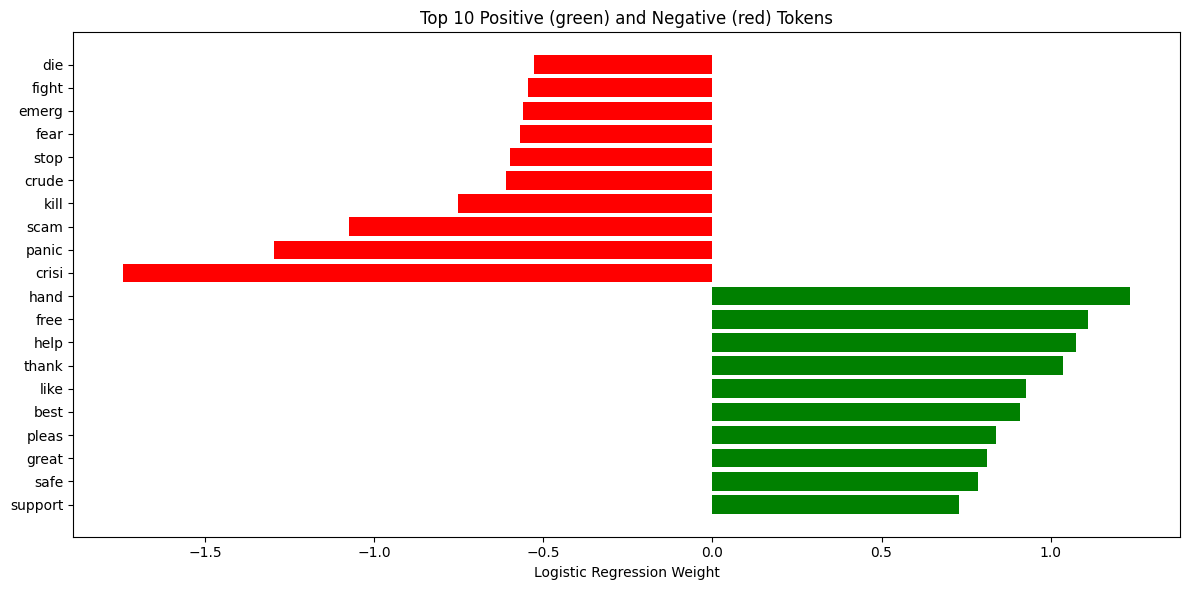

In [149]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
cv_final = CountVectorizer(
    tokenizer=custom_stem_tokenizer,
    token_pattern=None,
    min_df=11
)
X_train = cv_final.fit_transform(train['OriginalTweet'])
X_test = cv_final.transform(test['OriginalTweet'])
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
print("Train Accuracy:", logreg.score(X_train_scaled, y_train))
print("Test Accuracy:", logreg.score(X_test_scaled, y_test))

weights = logreg.coef_[0]
feature_names = cv_final.get_feature_names_out()
top_pos = np.argsort(weights)[-10:]
top_neg = np.argsort(weights)[:10]
plt.figure(figsize=(12, 6))
plt.barh(range(20),
         np.concatenate([weights[top_pos], weights[top_neg]]),
         color=['green']*10 + ['red']*10)
plt.yticks(range(20),
          np.concatenate([feature_names[top_pos], feature_names[top_neg]]))
plt.title("Top 10 Positive (green) and Negative (red) Tokens")
plt.xlabel("Logistic Regression Weight")
plt.tight_layout()
plt.show()

График наглядно показывает, какие слова сильнее всего влияют на предсказания модели, что помогает интерпретировать её решения.

Позитивные слова, такие как "help", "thank", "like", "best", "great", "safe", "pleas" и тд (эти токены, увеличивающие вероятность позитивного класса (1)) и негативные слова, такие как "die", "fight", "kill", "emergency", "fear", "panic" и тд (увеличивающие вероятность негативного класса (0)) имеют сильную эмоциональную окраску

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [150]:
# -- YOUR CODE HERE --
df[['UserName', 'ScreenName']].duplicated().any()

np.False_

**Ответ:** эти признаки бесполезны для модели как случайные идентификаторы (все значения уникальны), они не несут нам никакой доп инфы о эмоциональном окрашивание токенов и не участвуют ни в каких закономерностях

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

<Figure size 1200x500 with 0 Axes>

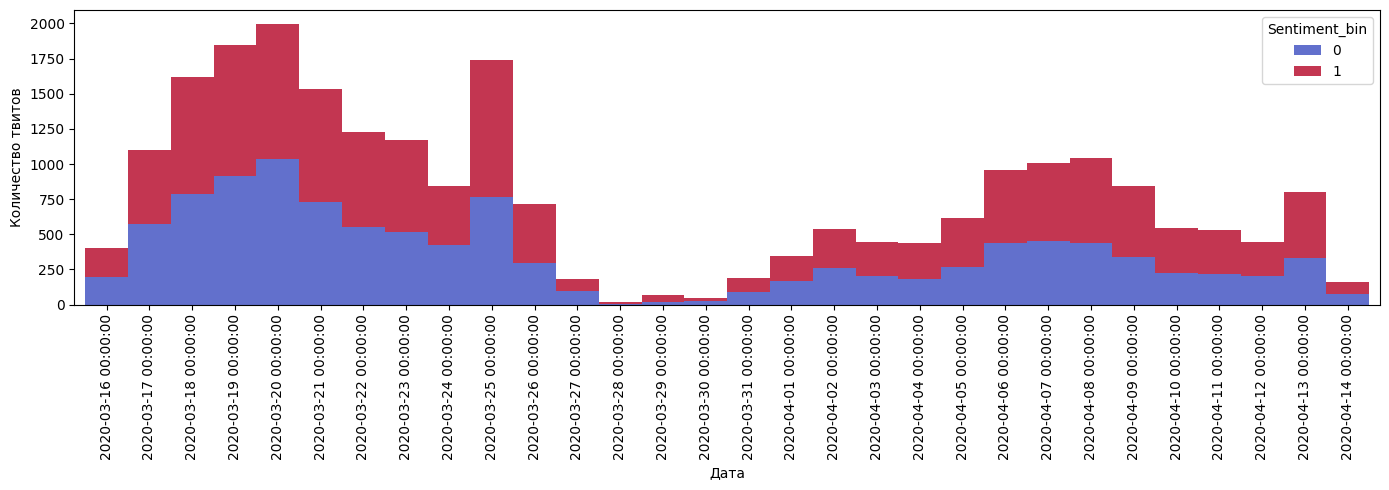

In [158]:
# -- YOUR CODE HERE --
train["TweetAt"] = pd.to_datetime(train["TweetAt"], dayfirst=True)
test["TweetAt"] = pd.to_datetime(test["TweetAt"], dayfirst=True)
plt.figure(figsize=(12, 5))
train.groupby(["TweetAt", "Sentiment_bin"]).size().unstack().plot(
    kind="bar", stacked=True, width=1.0, figsize=(14, 5), colormap="coolwarm", alpha=0.8
)
plt.xlabel("Дата")
plt.ylabel("Количество твитов")
plt.tight_layout()
plt.show()

**Ответ:** # из графика можно заметить зависимость sentiment от даты (события, настроения и новости меняются), наблюдаются временные закономерности, которые модель может использовать, следовательно можно сказать что этот признак может быть нам полезен

In [166]:
train["TweetAt_ordinal"] = train["TweetAt"].map(pd.Timestamp.toordinal)
test["TweetAt_ordinal"] = test["TweetAt"].map(pd.Timestamp.toordinal)
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
time_scaler = StandardScaler()
X_train_time = time_scaler.fit_transform(train[["TweetAt_ordinal"]])
X_test_time = time_scaler.transform(test[["TweetAt_ordinal"]])
X_train_all = hstack([X_train_scaled, X_train_time])
X_test_all = hstack([X_test_scaled, X_test_time])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_all, y_train)
y_pred = logreg.predict(X_test_all)
accuracy_score(y_test, y_pred)

0.8449272473589795

ну качество совсем немного увеличилось

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [169]:
train['Location'].nunique()

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

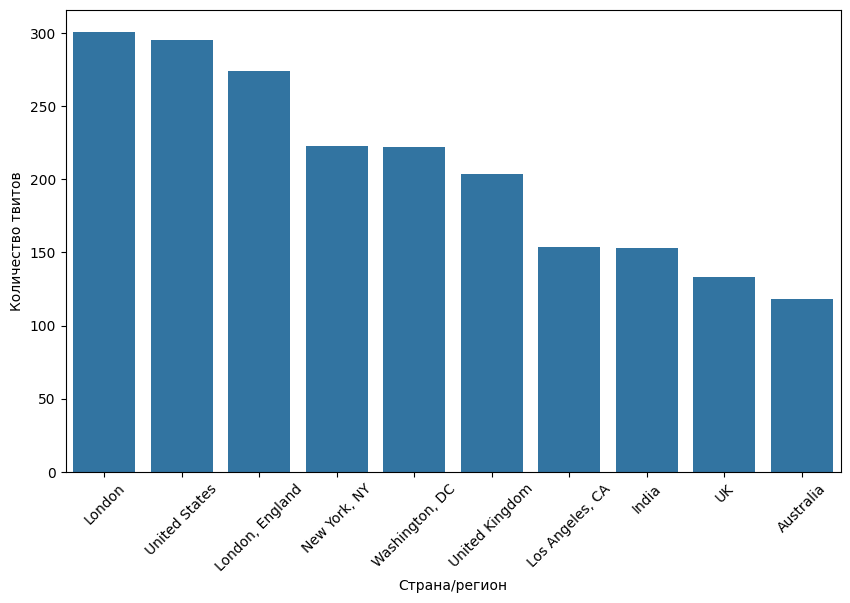

In [210]:
# -- YOUR CODE HERE --
loc_counts = train[train["Location"].fillna("Unknown").astype(str) != "Unknown"]["Location"].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=loc_counts.index, y=loc_counts.values)
plt.xlabel("Страна/регион")
plt.ylabel("Количество твитов")
plt.xticks(rotation=45)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [191]:
# -- YOUR CODE HERE --
def extract_wider_location(location):
    if pd.isna(location) or location.strip().lower() == "unknown":
        return "Unknown"
    if ',' in location:
        return location.split(',')[-1].strip()
    else:
        return location.strip()

train["WiderLocation"] = train["Location"].apply(extract_wider_location)
train["WiderLocation"].nunique()

4631

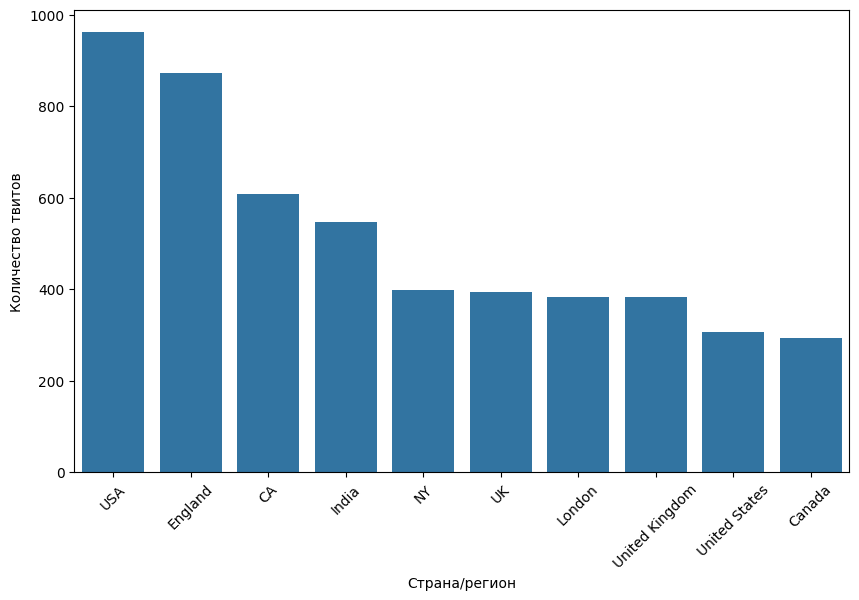

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

top_wide_locs = (train[train["WiderLocation"] != "Unknown"]["WiderLocation"].value_counts().head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=top_wide_locs.index, y=top_wide_locs.values)
plt.xlabel("Страна/регион")
plt.ylabel("Количество твитов")
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [215]:
# -- YOUR CODE HERE --
loc_counts = train["WiderLocation"].value_counts()
frequent_loc = loc_counts[loc_counts > 1].index
len(frequent_loc)

988

In [221]:
train["WiderLocationFiltered"] = train["WiderLocation"].apply(lambda x: x if x in frequent_loc else "Other")
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
loc_ohe = encoder.fit_transform(train[["WiderLocationFiltered"]])
loc_feature_names = encoder.get_feature_names_out(["WiderLocationFiltered"])
loc_ohe.shape[1]

989

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [223]:
# -- YOUR CODE HERE --
test["WiderLocation"] = test["Location"].apply(extract_wider_location)
loc_counts = train["WiderLocation"].value_counts()
frequent_loc = loc_counts[loc_counts > 1].index
train["WiderLocationFiltered"] = train["WiderLocation"].apply(lambda x: x if x in frequent_loc else "Other")
test["WiderLocationFiltered"] = test["WiderLocation"].apply(lambda x: x if x in frequent_loc else "Other")
categories = [sorted(train["WiderLocationFiltered"].unique())]
encoder = OneHotEncoder(categories=categories, handle_unknown='ignore', sparse_output=False)
train_loc_ohe = encoder.fit_transform(train[["WiderLocationFiltered"]])
test_loc_ohe = encoder.transform(test[["WiderLocationFiltered"]])
X_train_all = hstack([X_train_scaled, train_loc_ohe])
X_test_all = hstack([X_test_scaled, test_loc_ohe])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_all, y_train)
y_pred = logreg.predict(X_test_all)
accuracy_score(y_test, y_pred)

0.8445286027506478

**Ответ:** качество модели упало, потому что признак WiderLocationFiltered, даже после фильтрации, внёс больше шума, чем пользы